In [64]:
from world_machine_experiments import toy1d, shared
from world_machine_experiments.toy1d import Dimensions
from world_machine_experiments.toy1d import base, multiple, parameter_variation
from world_machine import WorldMachine

from hamilton import driver
from hamilton_sdk import adapters
from torch.optim import Adam, AdamW
import torch
import matplotlib.pyplot as plt
import numpy as np

In [65]:
d = driver.Builder().with_modules(base, shared).build()
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [66]:
inputs = {"sequence_lenght": 1000,
                       "n_sequence": 10000,#100,
                       "context_size": 200,
                       "state_dimensions": None,
                       "batch_size": 32,
                       "n_epoch": 5,
                       "learning_rate": 5e-3,
                       "weight_decay": 5e-4,
                       "accumulation_steps": 1,
                       "optimizer_class": AdamW,
                       "block_configuration": [Dimensions.STATE, Dimensions.NEXT_MEASUREMENT],#[Dimensions.NEXT_MEASUREMENT, Dimensions.NEXT_MEASUREMENT],
                       "device": device,
                       "use_state_control": False,
                       "discover_state": True, 
                       "stable_state_epochs": 1,
                       "seed":42,
                       "remove_positional_encoding":True,
                       "use_positional_encoding":False,
                       "output_dir":"test_autoregressive",
                       "state_activation":"clamp"
                       }

In [67]:
import os

os.makedirs("test_autoregressive", exist_ok=True)

In [68]:
outputs = d.execute(["toy1d_model_training_info", 
                     "toy1d_dataloaders", 
                     #"save_toy1d_autoregressive_state_plots", 
                     #"save_toy1d_autoregressive_positional_encoder_plots", 
                     #"save_toy1d_autoregressive_state_decoded_plots",
                     #"save_toy1d_autoregressive_metrics"
                     ], inputs=inputs)

100%|██████████| 250/250 [00:11<00:00, 22.62it/s]


VAL Epoch [0/5],             Loss: 0.3466


100%|██████████| 750/750 [00:46<00:00, 16.03it/s]


Epoch [1/5],             Loss: 0.0071, Elapsed Time: 46.90 sec


100%|██████████| 250/250 [00:11<00:00, 21.80it/s]


VAL Epoch [1/5],             Loss: 0.0003


100%|██████████| 750/750 [00:45<00:00, 16.61it/s]


Epoch [2/5],             Loss: 0.0003, Elapsed Time: 45.28 sec


100%|██████████| 250/250 [00:11<00:00, 21.73it/s]


VAL Epoch [2/5],             Loss: 0.0001


100%|██████████| 750/750 [00:53<00:00, 13.96it/s]


Epoch [3/5],             Loss: 0.0001, Elapsed Time: 53.83 sec


100%|██████████| 250/250 [00:07<00:00, 33.14it/s]


VAL Epoch [3/5],             Loss: 0.0001


100%|██████████| 750/750 [00:50<00:00, 14.84it/s]


Epoch [4/5],             Loss: 0.0001, Elapsed Time: 50.62 sec


100%|██████████| 250/250 [00:09<00:00, 25.58it/s]


VAL Epoch [4/5],             Loss: 0.0001


100%|██████████| 750/750 [01:10<00:00, 10.63it/s]


Epoch [5/5],             Loss: 0.0001, Elapsed Time: 70.75 sec


100%|██████████| 250/250 [00:19<00:00, 12.59it/s]

VAL Epoch [5/5],             Loss: 0.0001


In [69]:
dataloaders = outputs["toy1d_dataloaders"]
train_info = outputs["toy1d_model_training_info"]

model : WorldMachine = train_info["toy1d_model_trained"].eval()
train_loader = dataloaders["train"]
train_dataset = train_loader.dataset

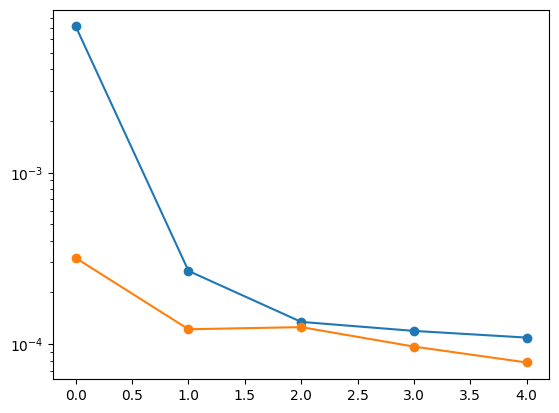

In [70]:
plt.plot(train_info["toy1d_train_history"]["optimizer_loss_train"], "o-")
plt.plot(train_info["toy1d_train_history"]["optimizer_loss_val"], "o-")

plt.yscale("log")
plt.show()

In [71]:
train_dataset[0]["inputs"]["state"].min(), train_dataset[0]["inputs"]["state"].max()

(tensor(-1.), tensor(1.))

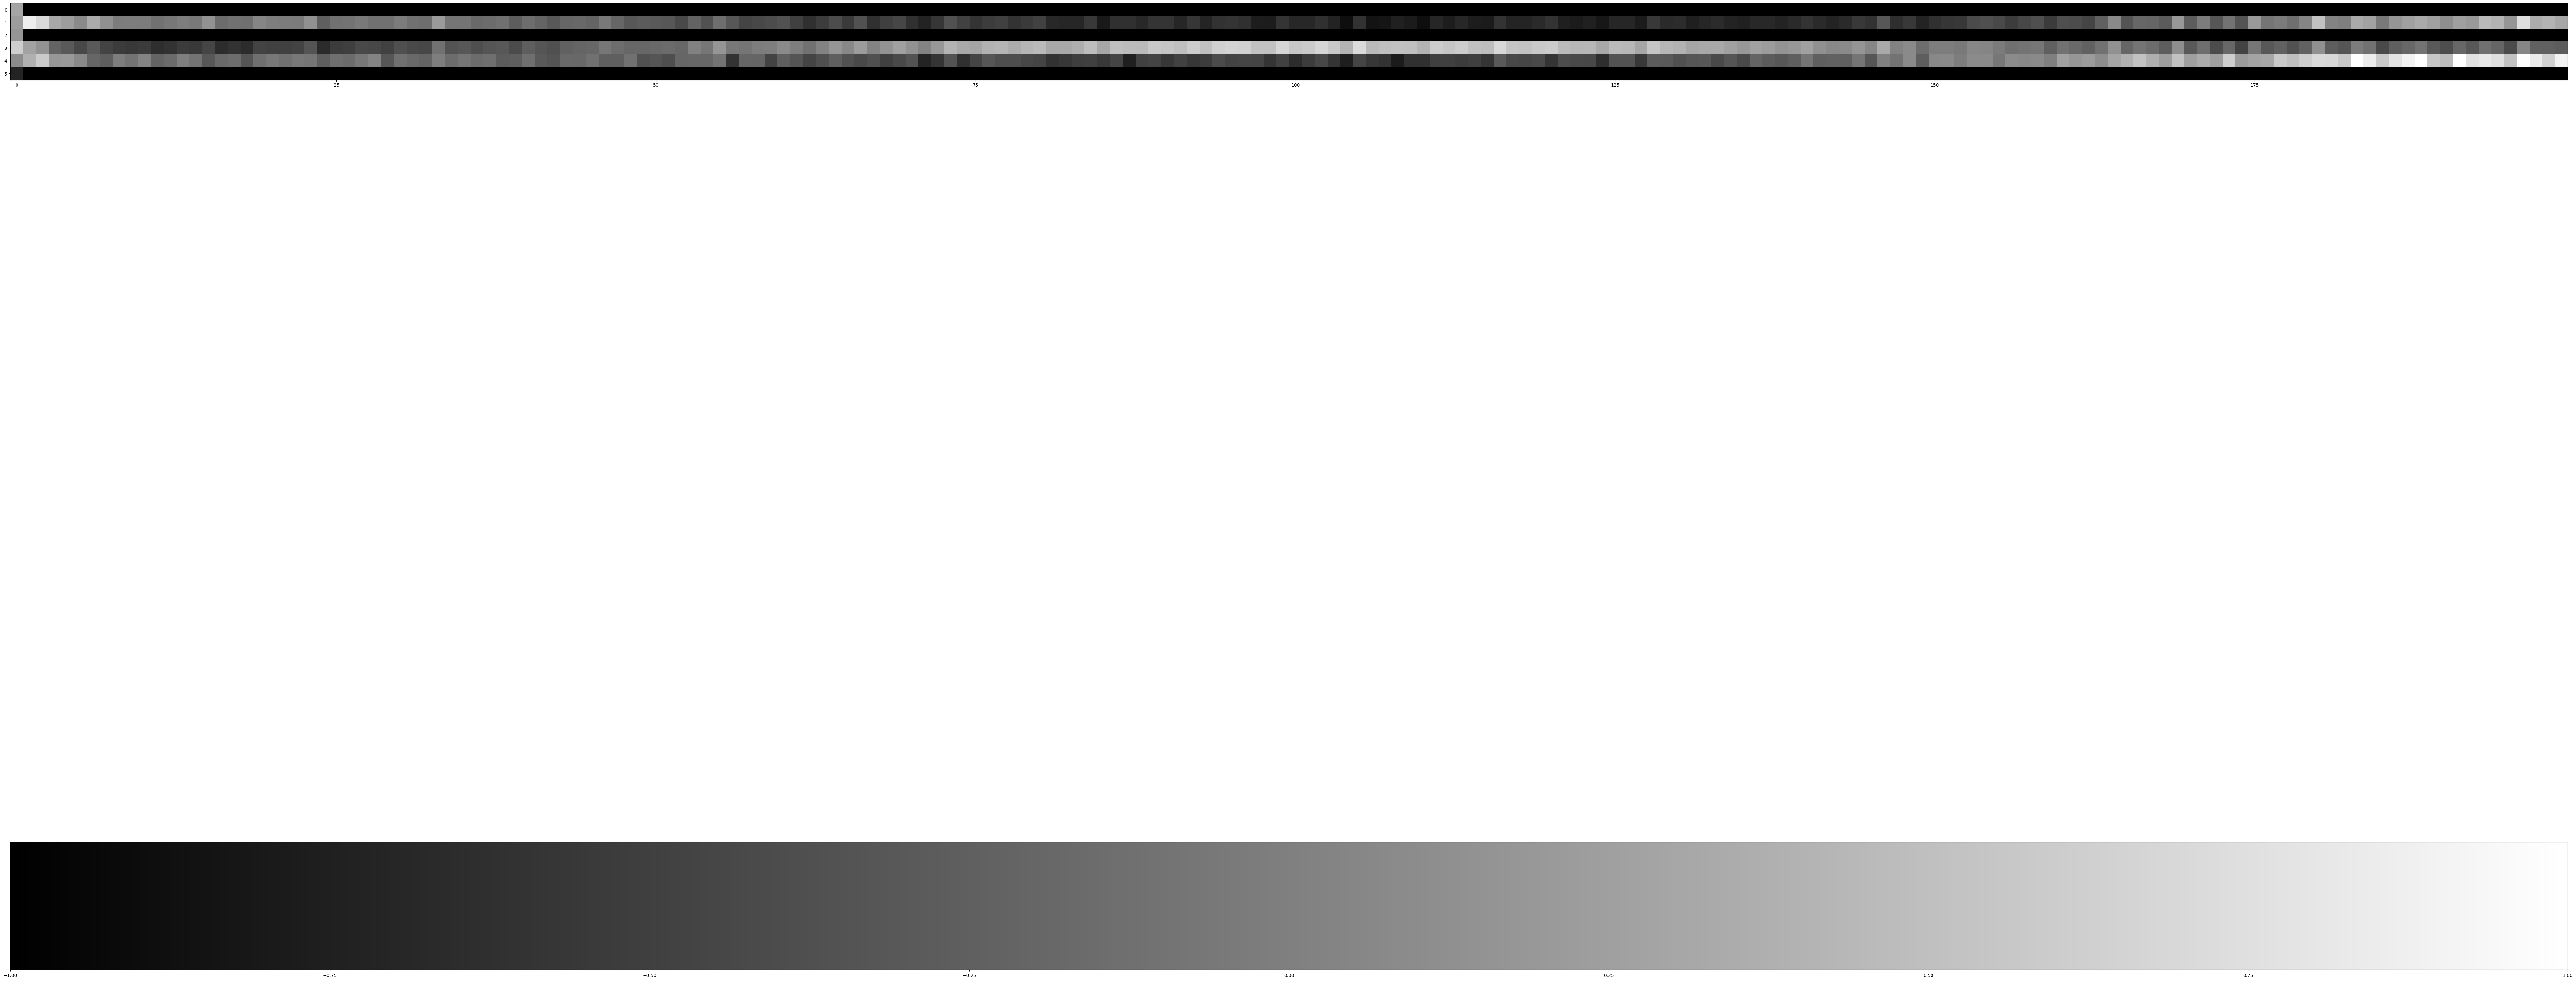

In [72]:

plt.figure(figsize=(100,200))
plt.imshow(train_dataset[0]["inputs"]["state"].T)

plt.gray()

plt.colorbar(orientation='horizontal')

plt.show()

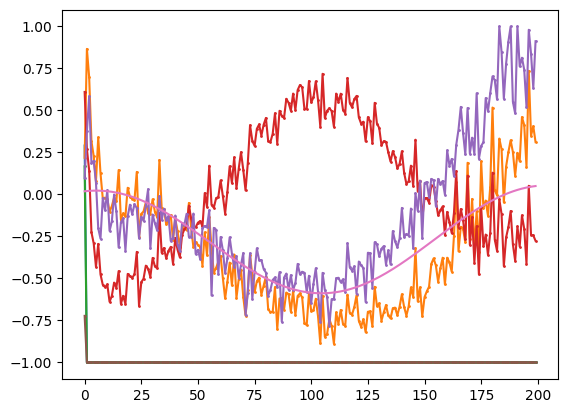

In [73]:
plt.plot(train_dataset[0]["inputs"]["state"], "o-", markersize=1)

plt.plot(train_dataset[0]["targets"]["state_decoded"][:,0])

In [74]:
item = next(iter(train_loader))

In [75]:
item["inputs"]["state"].min(), item["inputs"]["state"].max()

(tensor(-1.), tensor(1.))

In [76]:

inputs: torch.Tensor = item["inputs"].to(device)
targets: torch.Tensor = item["targets"]["state_decoded"]

state = inputs["state"]
sensorial_masks = None

with torch.no_grad():
    logits_orig = model(state=state, sensorial_data=inputs, sensorial_masks=sensorial_masks)

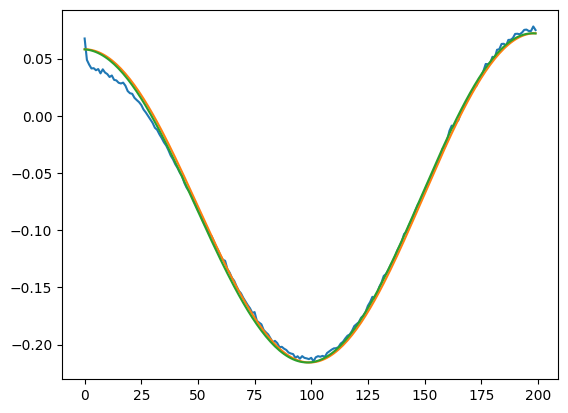

In [77]:
state_decoded = logits_orig["state_decoded"].cpu().numpy()

plt.plot(state_decoded[0 ,:,0])
plt.plot(inputs["state_decoded"][0,:,0].cpu())
plt.plot(targets[0,:,0].cpu())

In [78]:
batch_size = 32
seq_len = 200
state_size = 6

In [79]:
state_start = torch.rand((batch_size, seq_len, state_size), device=device)
state_start = (2*state_start)-1


In [80]:



inputs: torch.Tensor = item["inputs"].to(device)
targets: torch.Tensor = item["targets"]["state_decoded"]

state = state_start.clone()


model.eval()
sensorial_masks = None
results = {}

for case in range(2):
    
    with torch.no_grad():
        for i in range(seq_len):
            if case == 0:
                logits = model(state=state, sensorial_data=inputs, sensorial_masks=sensorial_masks)
            else:
                logits = model(state=state, sensorial_data=inputs, sensorial_masks=sensorial_masks, input_sequence_size=i+1)

            if i != seq_len-1:
                state[:, i+1] = logits["state"][:, i]

    if case == 0:
        results["full"] = state.clone()
    else:
        results["progressive"] = state.clone()

In [93]:
def full():
    with torch.no_grad():
        for i in range(seq_len):
            model(state=state, sensorial_data=inputs, sensorial_masks=sensorial_masks)

def progressive():
    with torch.no_grad():
        for i in range(seq_len):
            model(state=state, sensorial_data=inputs, sensorial_masks=sensorial_masks, input_sequence_size=i+1)

%timeit full()
%timeit progressive()

2.95 s ± 938 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.49 s ± 460 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Full: 2.9 s

Progressive: 2.1 s

In [81]:
state_progressive = results["progressive"]
state_full = results["full"]

In [82]:
torch.abs(state_progressive-state_full).sum()

tensor(0.0025, device='cuda:0')

In [85]:
mask = state_progressive!=state_full

state_progressive[mask], state_full[mask]

(tensor([ 0.2525,  0.9195,  0.8701,  ..., -0.0843, -0.1338, -0.0767],
        device='cuda:0'),
 tensor([ 0.2525,  0.9195,  0.8701,  ..., -0.0843, -0.1338, -0.0767],
        device='cuda:0'))

In [90]:
from numpy.testing import assert_array_almost_equal

assert_array_almost_equal(state_progressive.cpu(), state_full.cpu(), decimal=6)

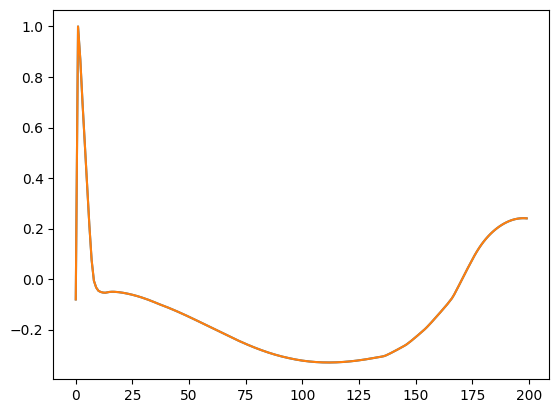

In [92]:
plt.plot(state_progressive[0, :, 1].cpu())
plt.plot(state_full[0, :, 1].cpu())

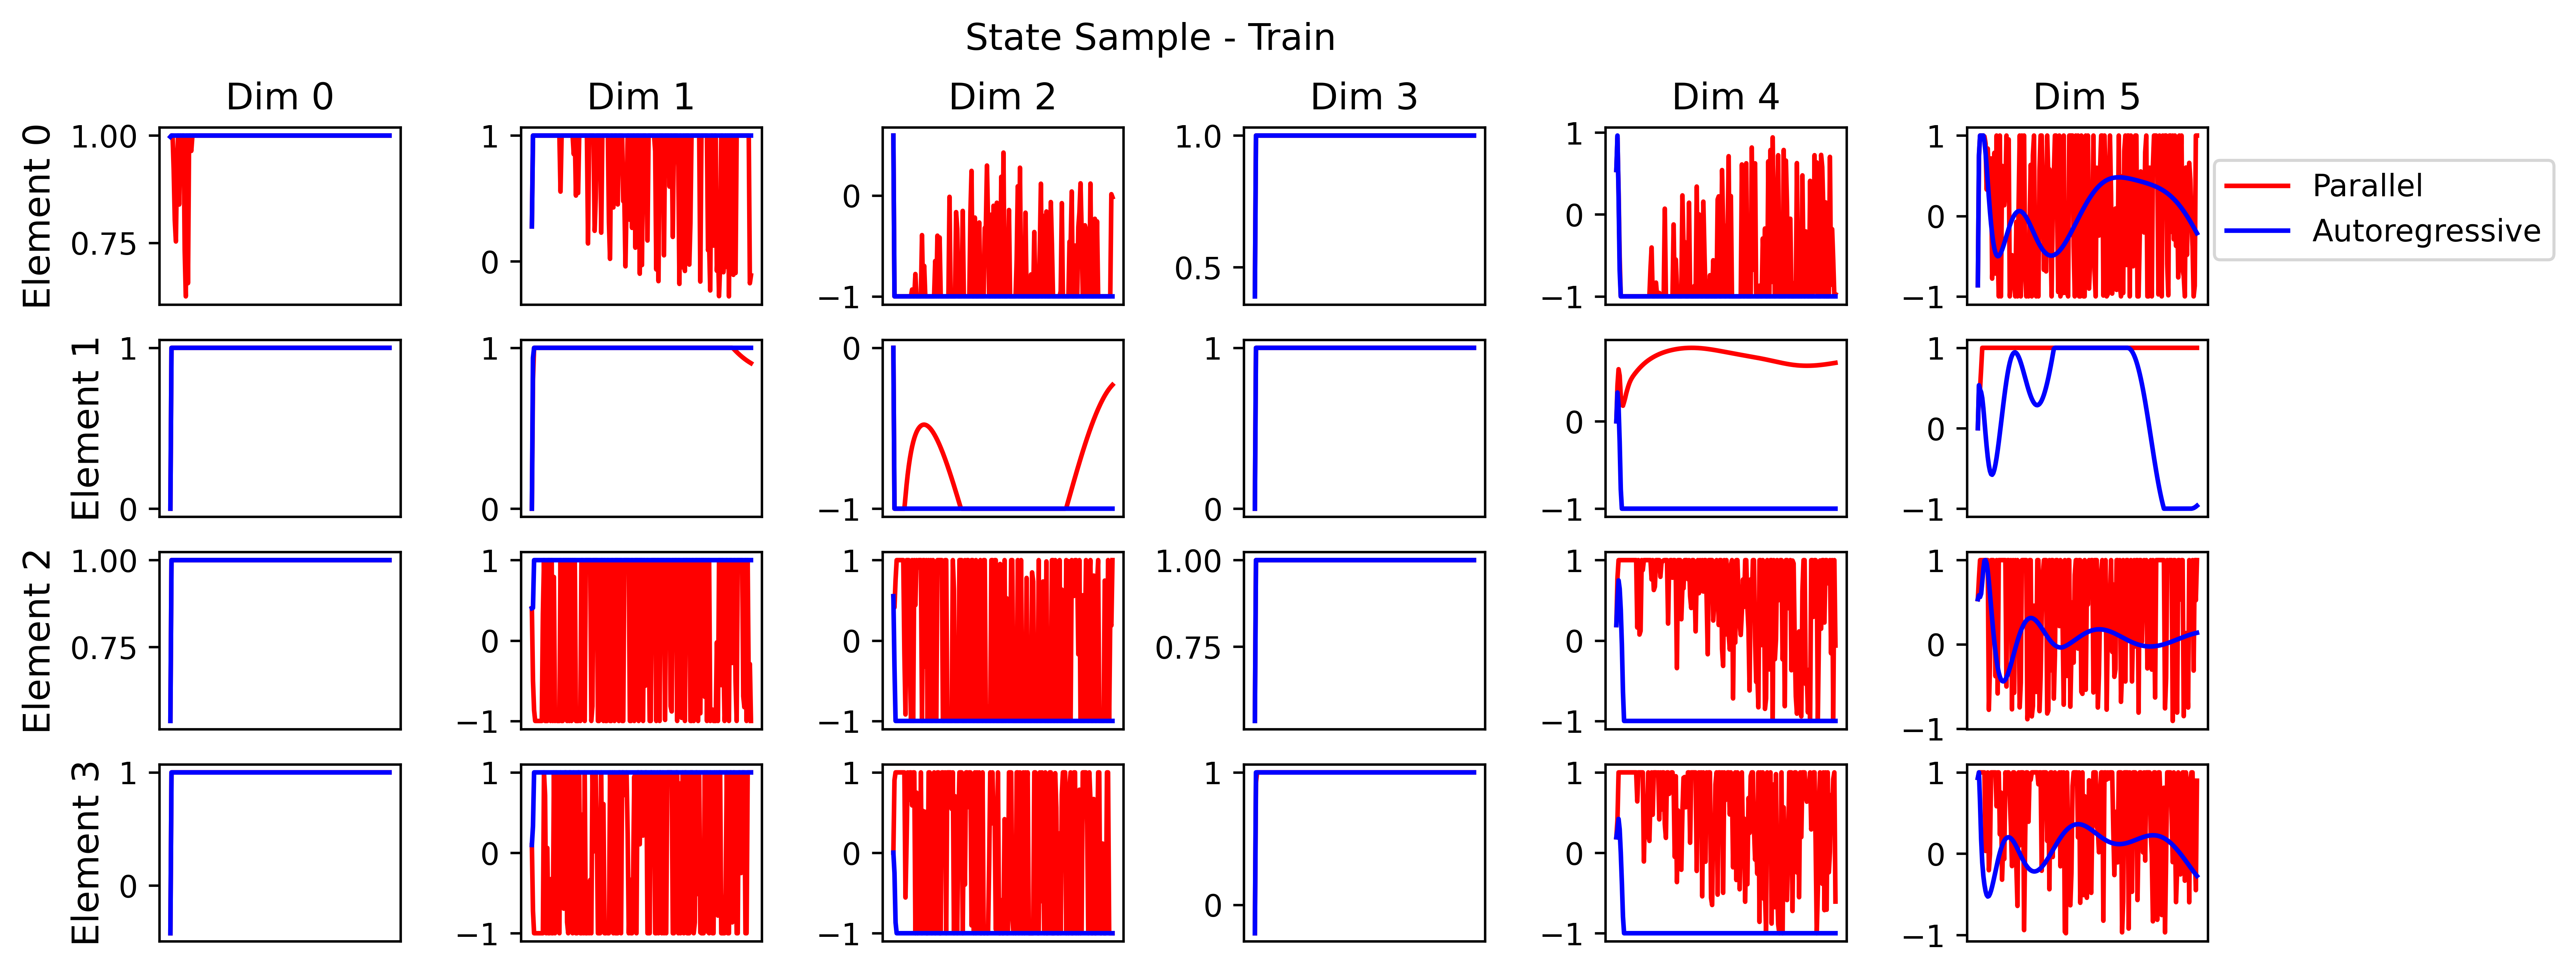

In [20]:
fig, axs = plt.subplots(4, 6, dpi=600, figsize=(12, 4.8))

fig.subplots_adjust(wspace=.5)

for i in range(24):
    row = i // 6
    column = i % 6

    axs[row, column].plot(inputs["state"][row, :, column].cpu(), color="red", label="Parallel")
    axs[row, column].plot(state[row, :, column].cpu(), color="blue", label="Autoregressive")
    axs[row, column].set_xticks([])
    #axs[row, column].set_yticks([])

for i in range(6):
    axs[0][i].set_title(f"Dim {i}")

for i in range(4):
    axs[i][0].set_ylabel(f"Element {i}", size="large")

plt.suptitle("State Sample - Train")
plt.legend(bbox_to_anchor=(2.5, 4.5), loc='upper right')
plt.show()

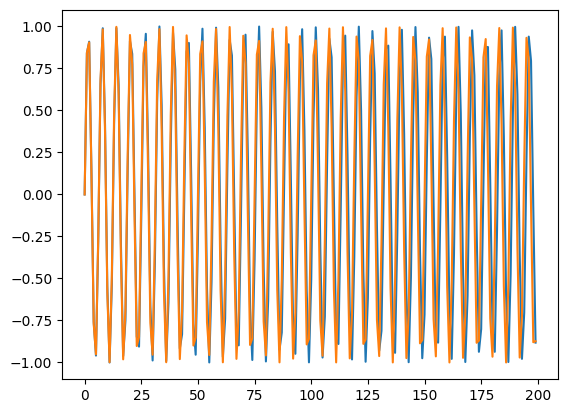

In [18]:
plt.plot(model._positional_encoder()[:,0].cpu())
plt.plot(np.sin(200*np.linspace(0,1, 200)))

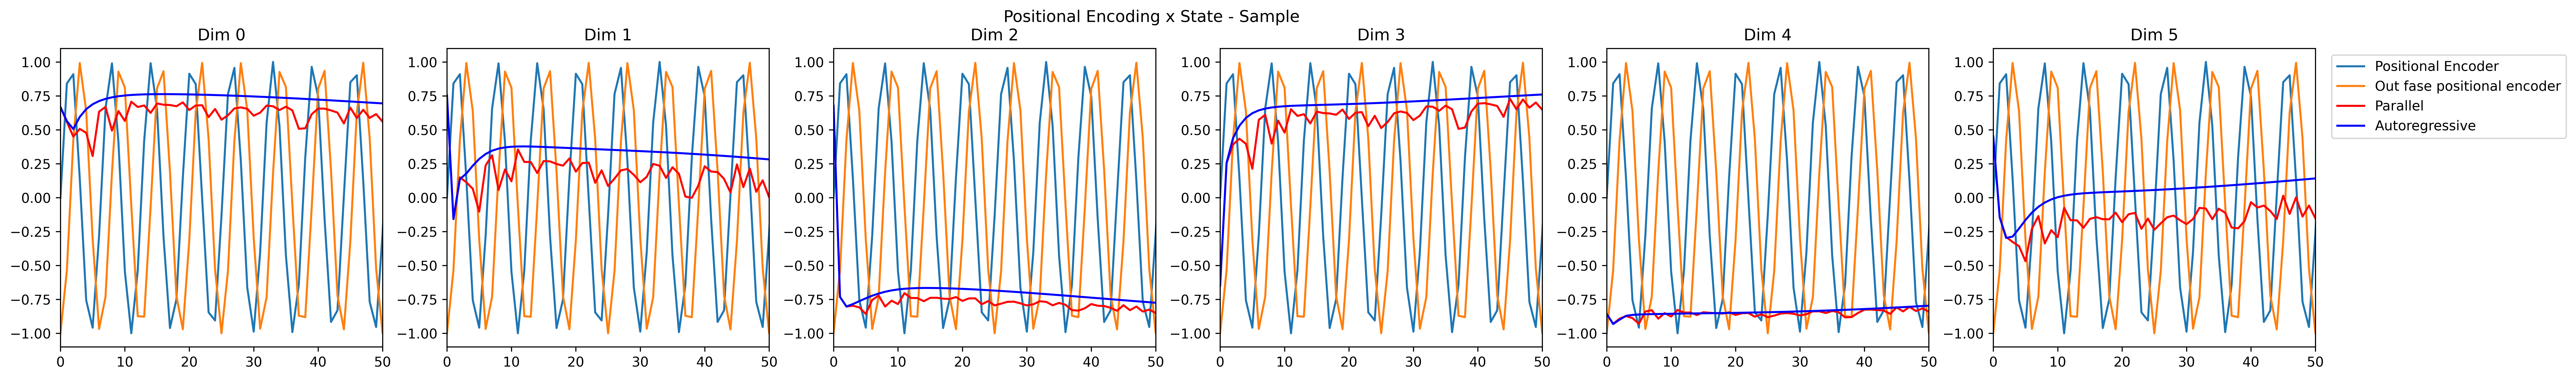

In [19]:
fig, axs = plt.subplots(1, 6, dpi=600, figsize=(30, 4))

for column in range(6):

    axs[column].plot(model._positional_encoder()[:,0].cpu(), label="Positional Encoder")
    axs[column].plot(-np.sin(200*np.linspace(0,1, 200) + (np.pi/2)), label="Out fase positional encoder")

    axs[column].plot(inputs["state"][0, :, column].cpu(), color="red", label="Parallel")
    axs[column].plot(state[0, :, column].cpu(), color="blue", label="Autoregressive")

    axs[column].set_xlim(0, 50)

    axs[column].set_title(f"Dim {column}")


plt.legend(bbox_to_anchor=(1.8, 1.0), loc='upper right')

plt.suptitle("Positional Encoding x State - Sample")

plt.show()

In [20]:
inputs["state"].shape

torch.Size([32, 200, 6])

In [21]:
for i in range(6):
    print(inputs["state"][0, :6, i].cpu(), state[0, :6, i].cpu())

tensor([0.6680, 0.5580, 0.4492, 0.5063, 0.4774, 0.3065]) tensor([0.6680, 0.5640, 0.5054, 0.5949, 0.6521, 0.6882])
tensor([ 0.7527, -0.1565,  0.1495,  0.1129,  0.0651, -0.1032]) tensor([ 0.7527, -0.1583,  0.1360,  0.1773,  0.2347,  0.2849])
tensor([ 0.6771, -0.7318, -0.8036, -0.7970, -0.8094, -0.8575]) tensor([ 0.6771, -0.7325, -0.8026, -0.7849, -0.7635, -0.7424])
tensor([-0.6493,  0.2540,  0.3906,  0.4340,  0.3967,  0.2129]) tensor([-0.6493,  0.2562,  0.4381,  0.5301,  0.5875,  0.6222])
tensor([-0.8570, -0.9305, -0.8924, -0.8737, -0.8883, -0.9301]) tensor([-0.8570, -0.9321, -0.8999, -0.8716, -0.8648, -0.8619])
tensor([ 0.4507, -0.1463, -0.2904, -0.3268, -0.3576, -0.4690]) tensor([ 0.4507, -0.1457, -0.2975, -0.2872, -0.2283, -0.1652])


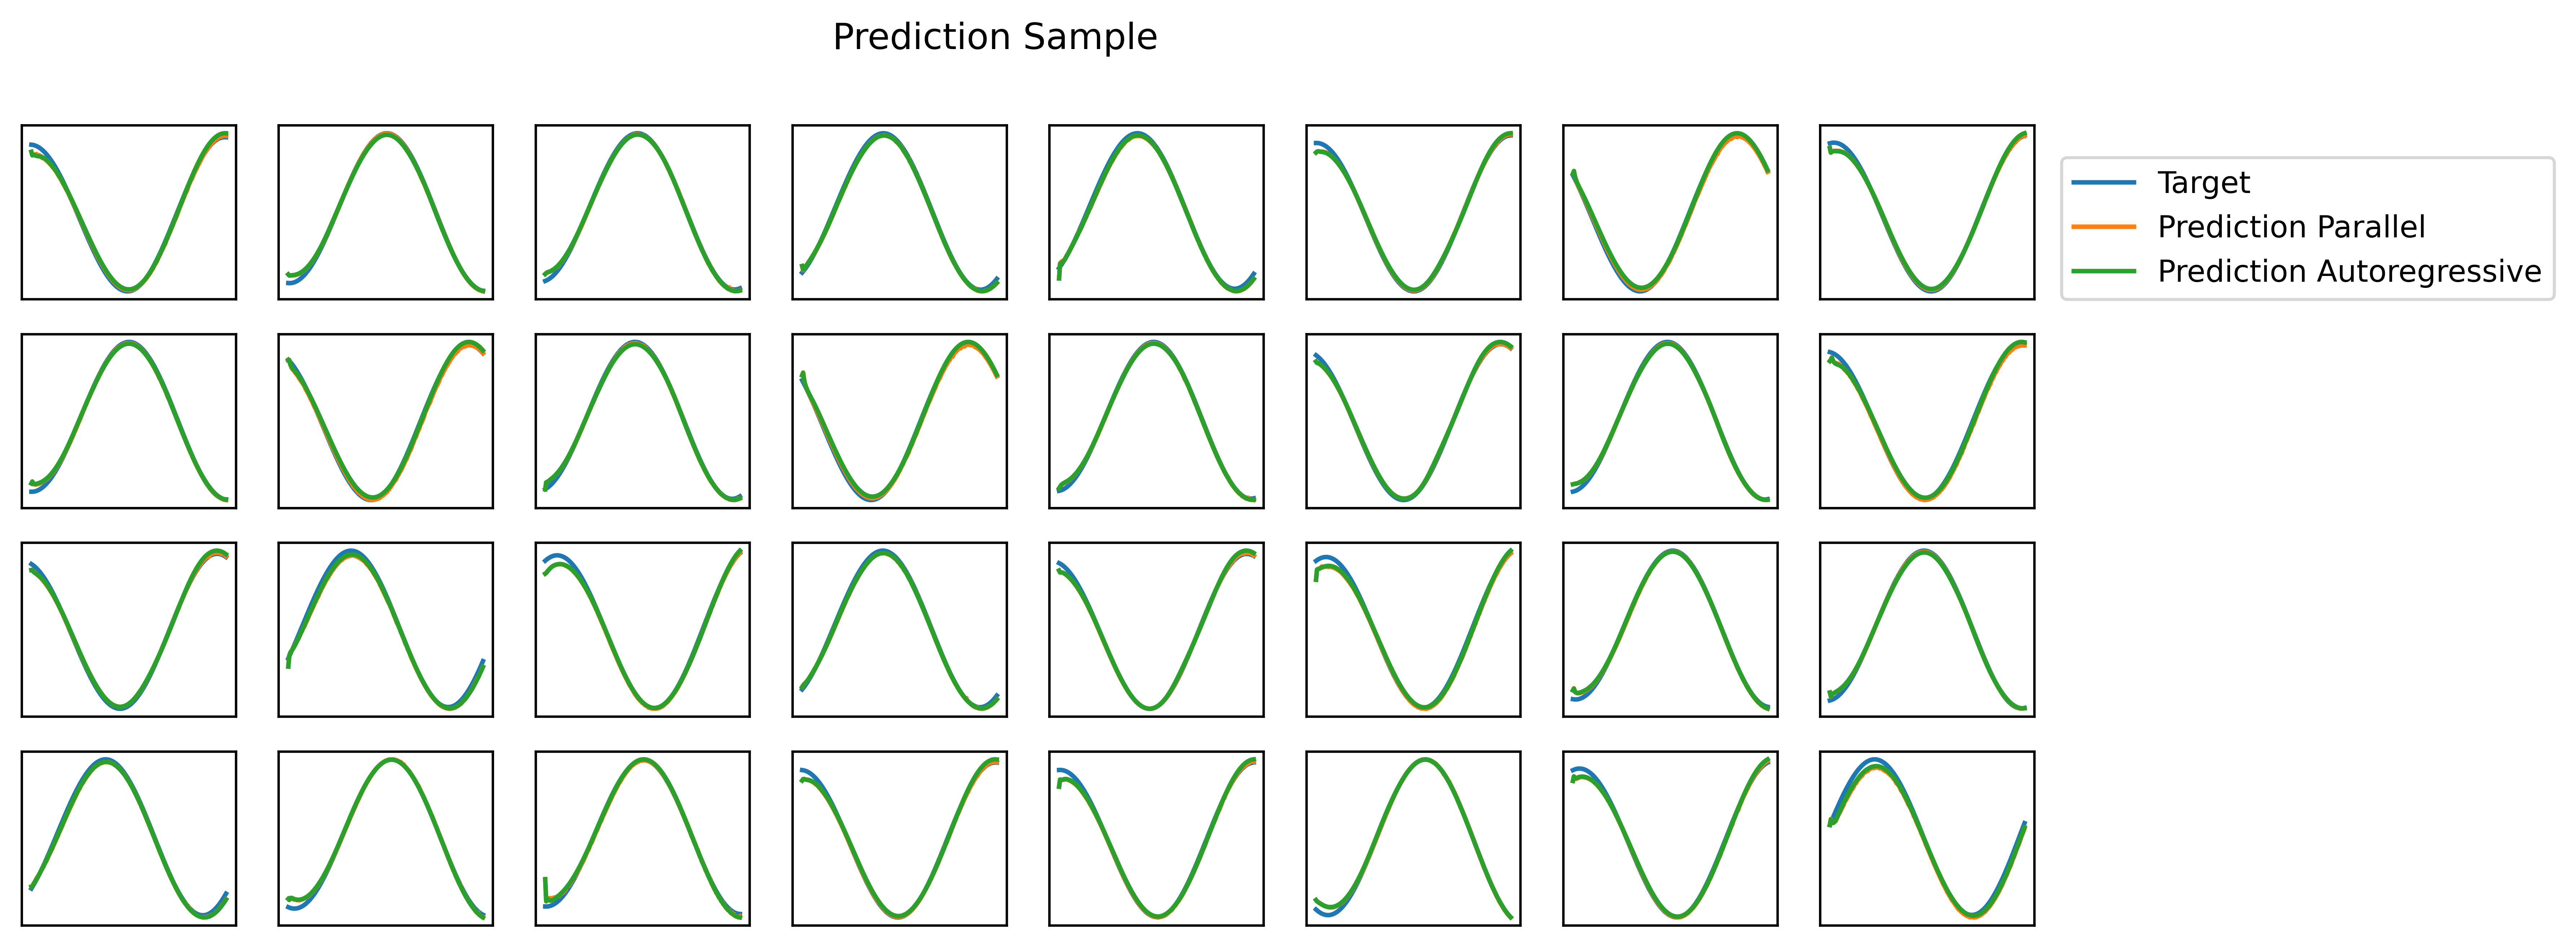

In [ ]:

fig, axs = plt.subplots(4, 8, dpi=600, figsize=(12, 4.8))

for i in range(32):
    row = i // 8
    column = i % 8

    axs[row, column].plot(targets[i,:,0].cpu(), label="Target")
    axs[row, column].plot(logits_orig["state_decoded"][i,:,0].cpu(), label="Prediction Parallel")
    axs[row, column].plot(logits["state_decoded"][i,:,0].cpu(), label="Prediction Autoregressive")

    axs[row, column].set_xticks([])
    axs[row, column].set_yticks([])

plt.suptitle("Prediction Sample - Parallel x Autoregressive")
plt.legend(bbox_to_anchor=(3.5, 4.5), loc='upper right')

plt.show()

In [ ]:
state_next = logits["state"]
state_current = torch.roll(state_next, 1, 1)
state_current[:, 0] = state[:, 0]

logits["state"][0], state_current[0]

(tensor([[ 1.0021,  1.1777, -0.0906,  0.9883, -2.2058,  0.4583],
         [ 2.1397,  2.2184, -0.5813,  1.6627, -1.9492,  0.2147],
         [ 2.1786,  2.2787, -0.9779,  1.5765, -1.8543, -0.1328],
         ...,
         [ 2.4130, -1.5399, -0.2130,  1.2896, -1.4617, -0.4912],
         [ 1.7888, -1.7208, -0.1076,  1.1637, -1.5033, -0.8295],
         [ 1.2150, -2.0224,  0.0860,  1.1503, -1.6580, -1.2253]],
        device='cuda:0'),
 tensor([[-0.1137,  0.0459,  0.6833,  0.2745,  0.8148,  0.2460],
         [ 1.0021,  1.1777, -0.0906,  0.9883, -2.2058,  0.4583],
         [ 2.1397,  2.2184, -0.5813,  1.6627, -1.9492,  0.2147],
         ...,
         [ 2.4430, -1.5922, -0.1397,  1.3768, -1.4895, -0.5246],
         [ 2.4130, -1.5399, -0.2130,  1.2896, -1.4617, -0.4912],
         [ 1.7888, -1.7208, -0.1076,  1.1637, -1.5033, -0.8295]],
        device='cuda:0'))

In [ ]:
logits["state"][0, :5, 0], state_current[0, :5, 0]

(tensor([1.0021, 2.1397, 2.1786, 1.5860, 0.8210], device='cuda:0'),
 tensor([-0.1137,  1.0021,  2.1397,  2.1786,  1.5860], device='cuda:0'))

In [ ]:
s = torch.rand((batch_size, seq_len, state_size), device=device)
s = (2*s)-1

state_next = logits["state"]
state_current = torch.roll(state_next, 1, 1)
state_current[:, 0] = s[:, 0]

state_current

tensor([[[-0.9763, -0.7068,  0.0745, -0.0320, -0.5950,  0.4246],
         [ 1.0021,  1.1777, -0.0906,  0.9883, -2.2058,  0.4583],
         [ 2.1397,  2.2184, -0.5813,  1.6627, -1.9492,  0.2147],
         ...,
         [ 2.4430, -1.5922, -0.1397,  1.3768, -1.4895, -0.5246],
         [ 2.4130, -1.5399, -0.2130,  1.2896, -1.4617, -0.4912],
         [ 1.7888, -1.7208, -0.1076,  1.1637, -1.5033, -0.8295]],

        [[-0.2451,  0.9626, -0.9358,  0.5759,  0.6717,  0.7191],
         [ 0.1033,  1.8529, -1.2884,  0.3224, -0.8159, -0.5246],
         [ 0.9088,  2.4777, -2.0135,  0.6716, -1.7372, -0.7785],
         ...,
         [ 3.0349, -1.4212, -1.0091,  1.5483,  0.4107, -0.9893],
         [ 3.0798, -1.4319, -1.1141,  1.5450,  0.5026, -1.1752],
         [ 2.4281, -1.6974, -0.7326,  1.4788,  0.6048, -1.5715]],

        [[ 0.4907,  0.3207,  0.4123,  0.0209,  0.6515,  0.8633],
         [ 1.3140, -0.5739, -0.0680,  0.9818, -0.8606,  0.1648],
         [ 2.6173,  0.3613,  0.2745,  2.0009, -1.5825,  0.

In [ ]:
train_dataset._states[:,0]

MemoryMappedTensor([[ 0.2802,  0.2986,  0.0741, -0.3524, -0.3373,  0.3827],
                    [-0.2254, -0.8381,  0.3532,  0.0768, -0.1994,  0.0920],
                    [-0.2926, -0.1458,  0.4503, -0.3358,  0.4715, -0.1239],
                    ...,
                    [ 0.2573,  0.1161,  0.1821,  0.3357, -0.2137,  0.2264],
                    [ 0.1959,  0.3436, -0.3100, -0.6022, -0.2043,  0.3443],
                    [-0.1309,  0.5898,  0.2834,  0.0601,  0.2064, -0.3254]])

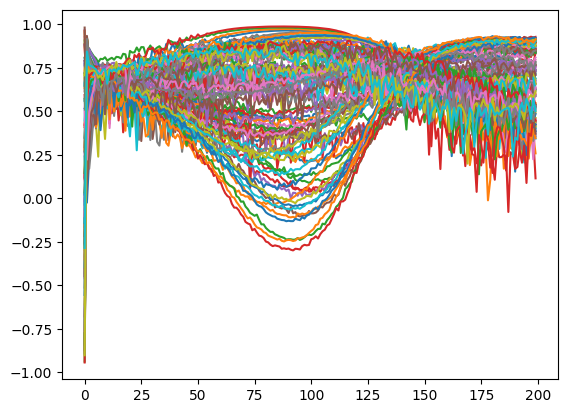

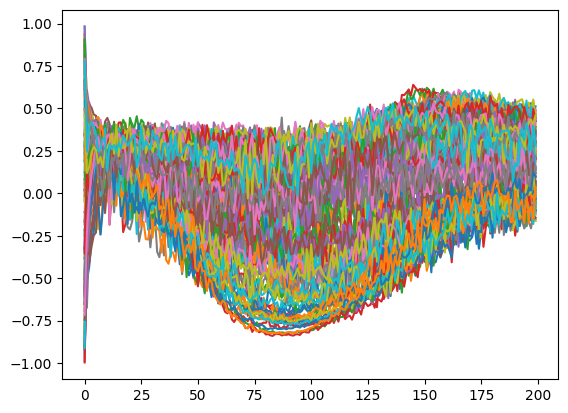

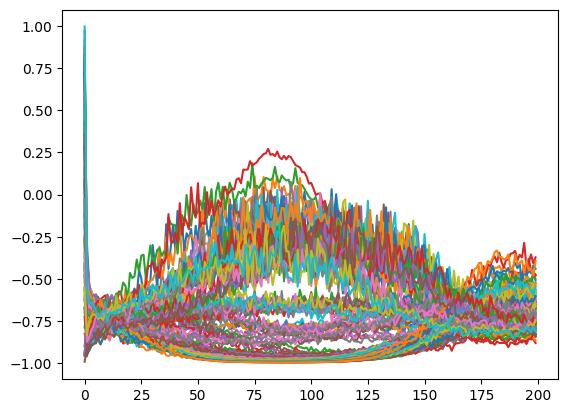

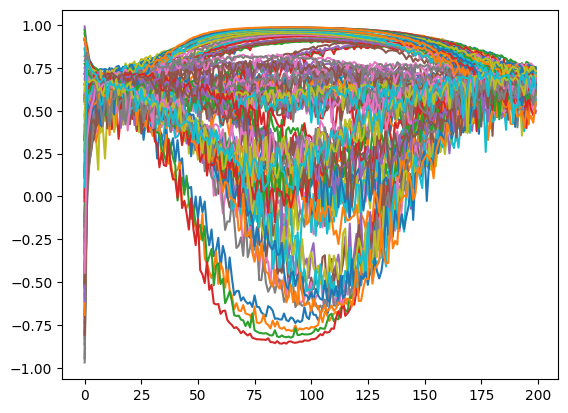

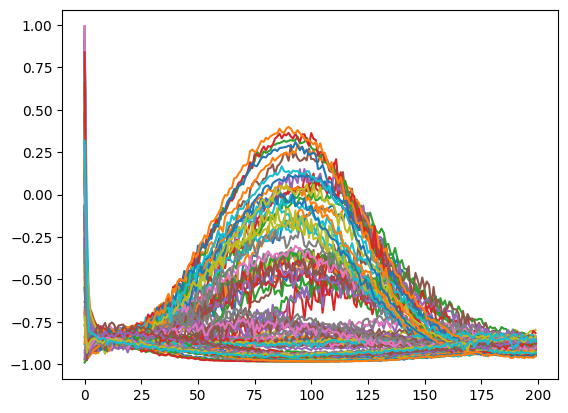

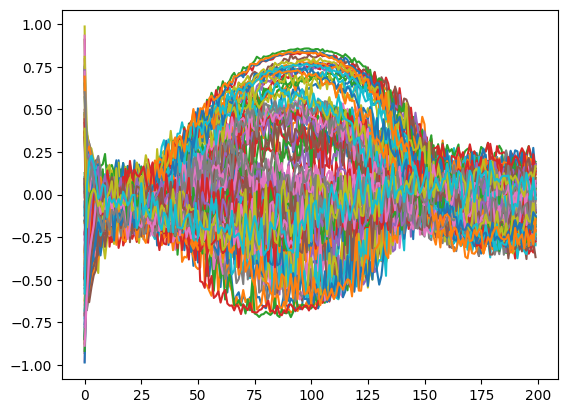

In [23]:
for dim in range(6):
    for i in range(100):
        plt.plot(train_dataset._states[i, :, dim])
    plt.show()

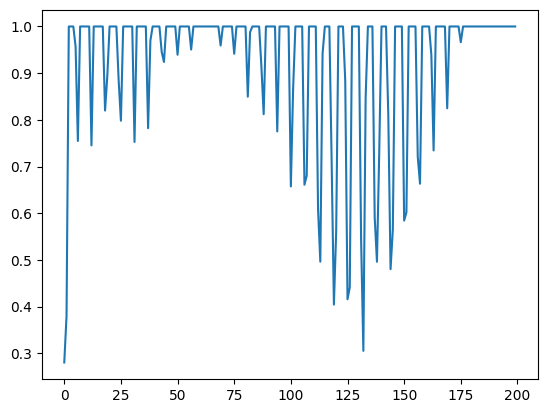

In [ ]:
plt.plot(train_dataset._states[0, :, 0])

In [26]:
val_loader = dataloaders["val"]

In [ ]:
mse = torch.nn.MSELoss()

with torch.no_grad():
    total_loss= torch.tensor(0, dtype=torch.float32, device=device)
    n = 0
    for item in val_loader:
        inputs: torch.Tensor = item["inputs"].to(device)
        targets: torch.Tensor = item["targets"]["state_decoded"].to(device)
        

        state = torch.rand((batch_size, seq_len, state_size), device=device)
        state = (2*state)-1

        state = torch.normal(
                                0.0, 0.4, (batch_size, seq_len, state_size), device=device)
        state = torch.clamp(state, -1, 1)

        sensorial_masks = None
        
        for i in range(seq_len):
            logits = model(state=state.clone(), sensorial_data=inputs, sensorial_masks=sensorial_masks)


            if i != seq_len-1:
                state[:, i+1] = logits["state"][:, i]

                state = torch.clamp(state, -1, 1)


        loss = mse(targets[:, :, 0], logits["state_decoded"][:, :, 0])
        total_loss += loss *targets.size(0)

        n += targets.size(0)

    total_loss = total_loss.item()
    total_loss /= n

total_loss

7.16586709022522e-05

In [29]:
train_info["toy1d_train_history"]["state_decoded_mse_first_val"][-1]

7.28987215552479e-05

Method|MSE
-|-
Parallel | 7.28987215552479e-05
Autoregressive| 7.16586709022522e-05

In [30]:
total_loss/train_info["toy1d_train_history"]["state_decoded_mse_first_val"][-1]

0.9829894046625234

In [32]:
t = torch.empty_like(train_loader.dataset._states, device="cpu")

In [33]:
t.element_size()*t.nelement()/1e6 #Mb

115.2

In [21]:
import glob

In [30]:
experiment_paths_list = glob.glob("toy1d_autoregressive\\*")
experiment_names = []
experiment_paths = {}

for path in experiment_paths_list:
    if not os.path.isdir(path):
        continue

    name = os.path.basename(path)
    experiment_names.append(name)

    experiment_paths[name] = path

experiment_paths

{'Base': 'toy1d_autoregressive\\Base',
 'NoPE': 'toy1d_autoregressive\\NoPE',
 'NoPE_Clamp': 'toy1d_autoregressive\\NoPE_Clamp',
 'NoPE_Tanh': 'toy1d_autoregressive\\NoPE_Tanh',
 'RemovePE': 'toy1d_autoregressive\\RemovePE',
 'RemovePE_Tanh': 'toy1d_autoregressive\\RemovePE_Tanh',
 'Tanh': 'toy1d_autoregressive\\Tanh'}

In [31]:
import json

autoregressive_metrics = {}

for name in experiment_names:
    metrics_path = os.path.join(experiment_paths[name], "run_0", "autoregressive_metrics.json")

    with open(metrics_path, "r") as file:
        autoregressive_metrics[name] = json.load(file)

In [35]:
print("Train")

for name in experiment_names:
    print(name, autoregressive_metrics[name]["proportion"]["train"])

print("\nVal")

for name in experiment_names:
    print(name, autoregressive_metrics[name]["proportion"]["val"])

Train
Base 54.661924114380525
NoPE 8.813999607417962
NoPE_Clamp 3.3269080467176364
NoPE_Tanh 1.8204973197771
RemovePE 14.377367189604303
RemovePE_Tanh 2.125302582343566
Tanh 1.1469675889541193

Val
Base 70.58517041461388
NoPE 10.553467049434026
NoPE_Clamp 4.018013841897416
NoPE_Tanh 2.5099032249664948
RemovePE 11.956226972427901
RemovePE_Tanh 2.682710322044844
Tanh 1.4401915727069474


0.00014300978183746338
0.00009531008981866762